### PRAKTIKUM

Logistic Regresion

Import Library

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

Connect to gdrive

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Membaca data file CSV


In [18]:
df = pd.read_csv("/content/gdrive/MyDrive/Praktikum_ML/Praktikum04/data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


Melihat informasi umum dataset

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


Data Pre-proccesing

cek missing value

In [20]:
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [21]:
df.duplicated().sum()

np.int64(7308)

In [22]:
df = df.drop_duplicates()

In [42]:
df.duplicated().sum()

np.int64(0)

cek nilai unik

In [23]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [24]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

Mapping kolom kategorik ke bentuk numerik

In [25]:
# 1. Mapping kolom Stunting -> biner
map_stunt = {'Stunted': 1, 'Severely Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

# 2. Mapping kolom Jenis Kelamin -> biner
# Laki-laki = 1, Perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    72320
1    20372
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    46353
0    46339
Name: count, dtype: int64


Analisis Kolerasi Antar Variable Numerik

In [26]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.874162,0.659566,0.037173,0.000636
Tinggi Badan (cm),0.874162,1.000000,0.618453,-0.288216,0.070159
Berat Badan (kg),0.659566,0.618453,1.000000,0.020676,0.043446
Stunting_bin,0.037173,-0.288216,0.020676,1.000000,-0.005187
JK_bin,0.000636,0.070159,0.043446,-0.005187,1.000000


Visualisasi Heatmap Kolerasi

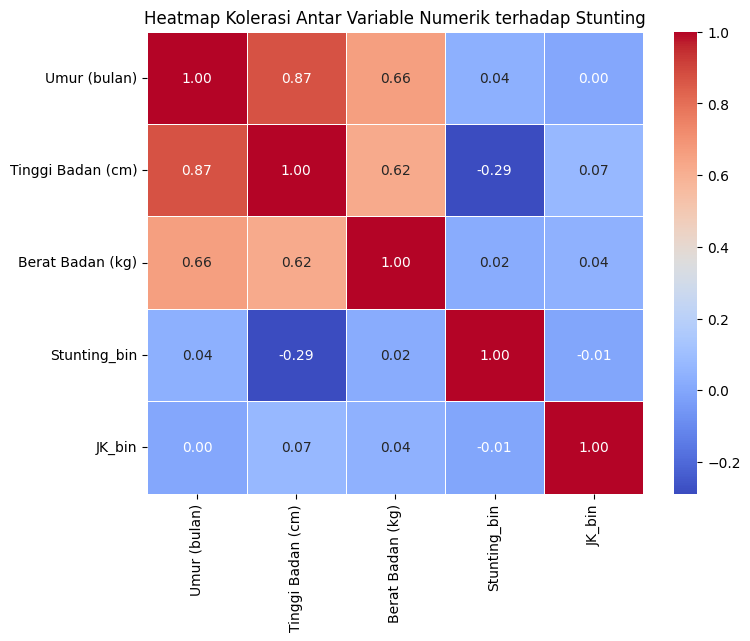

In [27]:
# Visualisasi heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Kolerasi Antar Variable Numerik terhadap Stunting", fontsize=12)
plt.show()

Pembagian Dataset (Training dan Testing)

menentukan fitur dan target


In [28]:
# Fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# Gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model [feature_num + feature_bin]
y = df_model ['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (92692, 4)
y shape: (92692,)


Membagi Dataset menjadi Training dan Testing Set

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (74153, 4)
Data uji: (18539, 4)


Pembangunan Model Logistic Regression

In [30]:
# Scale hanya fitur numerik, gender langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logostic Regression berhasil dilatih.")

✅ Model Logostic Regression berhasil dilatih.


Prediksi Model dan Evaluasi Model

In [31]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

# Hitung metrik
print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC   : {roc_auc_score (y_test, y_prob):.4f}")

Akurasi   : 0.9063
Precision : 0.7139
Recall    : 0.9571
F1-Score  : 0.8178
ROC-AUC   : 0.9651


Visualisasi Hail Evaluasi

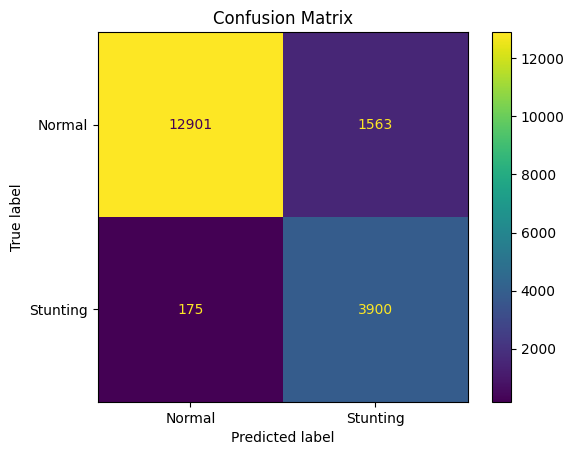

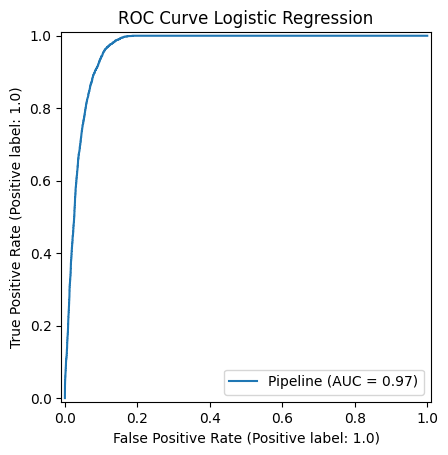

In [32]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Normal', 'Stunting']
                       ).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

#ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

Classification Report

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting(0)', 'Stunting']))

                   precision    recall  f1-score   support

Tidak Stunting(0)       0.99      0.89      0.94     14464
         Stunting       0.71      0.96      0.82      4075

         accuracy                           0.91     18539
        macro avg       0.85      0.92      0.88     18539
     weighted avg       0.93      0.91      0.91     18539



Classification Report

In [34]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation (cv=5 brarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

Skor tiap fold: [0.9084093  0.90414801 0.90468227 0.90673212 0.9028482 ]
Rata-rata akurasi: 0.9053639814725255
Standar deviasi: 0.001970695381359219


Interpretasi Model Logistic Regression

In [35]:
# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps ['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.661420,5775.733054
3,JK_bin,1.726339,5.620042
2,Berat Badan (kg),0.653153,1.921590
1,Tinggi Badan (cm),-10.742834,0.000022


Prediksi Data Baru (Contoh Kasus)

In [36]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0] # 1=Laki-Laki, 0=Perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.998346,1.0
1,10,72.5,7.8,0,0.001810,0.0


## PRAKTIKUM MANDIRI

In [37]:
# Membaca file CSV
import pandas as pd

df = pd.read_csv("/content/gdrive/MyDrive/Praktikum_ML/Praktikum04/data/calonpembelimobil.csv")
df.head()

,ID,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Beli_Mobil
0,1,32,1,0,0,240,1
1,2,49,2,1,1,100,0
2,3,52,1,0,2,250,1
3,4,26,2,1,1,130,0
4,5,45,3,0,2,237,1


In [38]:
# Melihat informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ID              1000 non-null   int64
 1   Usia            1000 non-null   int64
 2   Status          1000 non-null   int64
 3   Kelamin         1000 non-null   int64
 4   Memiliki_Mobil  1000 non-null   int64
 5   Penghasilan     1000 non-null   int64
 6   Beli_Mobil      1000 non-null   int64
dtypes: int64(7)
memory usage: 54.8 KB


In [39]:
# Cek missing value
df.isnull().sum()

,0
ID,0
Usia,0
Status,0
Kelamin,0
Memiliki_Mobil,0
Penghasilan,0
Beli_Mobil,0


In [40]:
# Menganalisis korelasi antar variabel numerik
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,ID,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Beli_Mobil
ID,1.000000,0.149779,-0.006634,0.014646,0.068555,0.254177,0.168614
Usia,0.149779,1.000000,0.051476,0.019454,0.090926,0.125859,0.100127
Status,-0.006634,0.051476,1.000000,-0.008561,0.048302,0.071714,0.048584
Kelamin,0.014646,0.019454,-0.008561,1.000000,0.035199,-0.054211,-0.147301
Memiliki_Mobil,0.068555,0.090926,0.048302,0.035199,1.000000,0.137823,0.102005
Penghasilan,0.254177,0.125859,0.071714,-0.054211,0.137823,1.000000,0.763930
Beli_Mobil,0.168614,0.100127,0.048584,-0.147301,0.102005,0.763930,1.000000


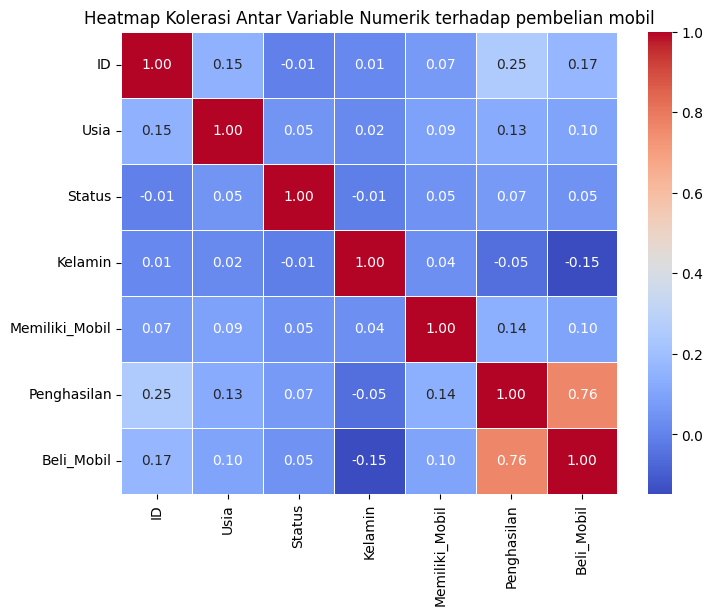

In [41]:
# Visualisasi heatmap korelasi
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Kolerasi Antar Variable Numerik terhadap pembelian mobil", fontsize=12)
plt.show()

In [59]:
# Menentukan Fitur dan Target

# Fitur numerik dan gender
feature_num = ['Usia', 'Status', 'Kelamin', 'Memiliki_Mobil']
feature_bin = ['Penghasilan']

# Gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Beli_Mobil']
df_model = df[use_cols].dropna().copy()

X = df_model [feature_num + feature_bin]
y = df_model ['Beli_Mobil']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1000, 5)
y shape: (1000,)


In [44]:
# Membagi Dataset menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (800, 5)
Data uji: (200, 5)


In [45]:
# Pembangunna model logistic regression

# Scale hanya fitur numerik
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")

✅ Model Logistic Regression berhasil dilatih.


In [48]:
# Prediksi model dan evaluasi

# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi    : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision  : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall     : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score   : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC    : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi    : 0.9300
Precision  : 0.9748
Recall     : 0.9134
F1-Score   : 0.9431
ROC-AUC    : 0.9770


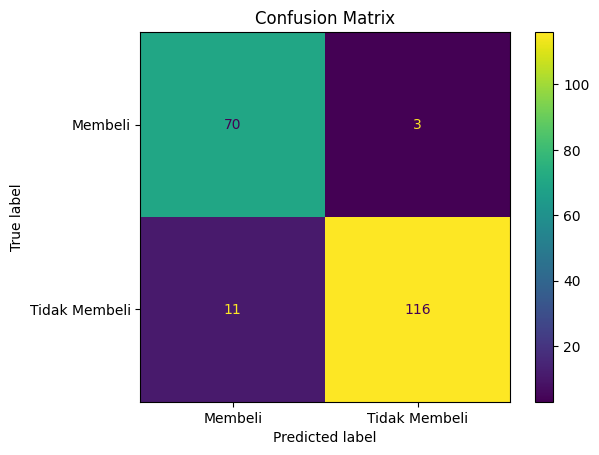

In [54]:
#Visualisasi hasil evaluasi

# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                        display_labels=['Membeli', 'Tidak Membeli']
                       ).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

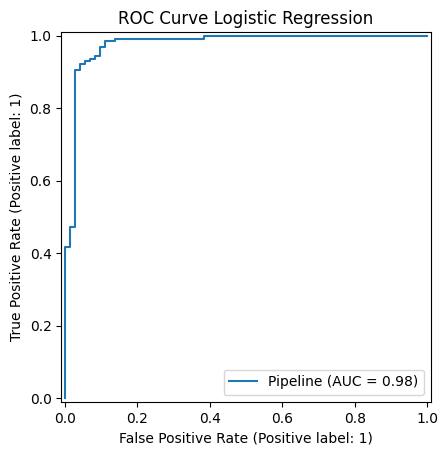

In [50]:
# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

In [55]:
#Classification Report

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Membeli (0)', 'Membeli (1)']))

                   precision    recall  f1-score   support

Tidak Membeli (0)       0.86      0.96      0.91        73
      Membeli (1)       0.97      0.91      0.94       127

         accuracy                           0.93       200
        macro avg       0.92      0.94      0.93       200
     weighted avg       0.93      0.93      0.93       200



In [52]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

Skor tiap fold: [0.785 0.91  0.955 0.945 0.94 ]
Rata-rata akurasi: 0.907
Standar deviasi: 0.06281719509815761


In [56]:
#Interpretasi model logistic  regression

# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
3,Memiliki_Mobil,0.083176,1.086733
4,Penghasilan,0.055951,1.057546
0,Usia,-0.082246,0.921045
1,Status,-0.168034,0.845325
2,Kelamin,-0.655173,0.519352


In [58]:
# Contoh 2 calon pembeli mobil baru
data_baru = pd.DataFrame({
    'Usia': [25, 45],
    'Status': [1, 0],          # 1 = Menikah, 0 = Belum Menikah
    'Kelamin': [1, 0],         # 1 = Laki-laki, 0 = Perempuan
    'Memiliki_Mobil': [0, 1],  # 0 = Belum punya mobil, 1 = Sudah punya
    'Penghasilan': [8000000, 4000000]
})

# Prediksi (0=Tidak Beli, 1=Beli)
pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

# Gabungkan hasil prediksi dan probabilitas ke dalam tabel
hasil = data_baru.copy()
hasil['Prob_BeliMobil'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred

display(hasil)

,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Prob_BeliMobil,"Pred (0=Tidak,1=Ya)"
0,25,1,1,0,8000000,1.0,1
1,45,0,0,1,4000000,1.0,1


In [60]:
from google.colab import drive
drive.mount('/content/drive')

!git config --global user.email "ariakristallnacht@gmail.com"
!git config --global user.name "Aria Kristallincht"

!git clone https://github.com/Ariakristallnacht/TI03_AriaKS_0110222076.git
%cd   TI03_AriaKS_0110222076

!cp -r /content/drive/MyDrive/Praktikum_ML/Praktikum03/ ./Praktikum04

!ls -lah

!git add .
!git commit -m "praktikum 3 ml"

from getpass import getpass
import os

token = getpass("Masukkan GitHub Token: ")

os.system(f'git remote set-url origin https://{token}@github.com/Ariakristallnacht/TI03_AriaKS_0110222076.git')

!git push origin main

Mounted at /content/drive
Cloning into 'TI03_AriaKS_0110222076'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 39 (delta 4), reused 37 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 2.59 MiB | 18.44 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/TI03_AriaKS_0110222076
total 24K
drwxr-xr-x 6 root root 4.0K Oct 19 08:45 .
drwxr-xr-x 1 root root 4.0K Oct 19 08:45 ..
drwxr-xr-x 8 root root 4.0K Oct 19 08:45 .git
drwxr-xr-x 5 root root 4.0K Oct 19 08:45 Praktikum01
drwxr-xr-x 5 root root 4.0K Oct 19 08:45 Praktikum02
drwxr-xr-x 6 root root 4.0K Oct 19 08:45 Praktikum03
[main 9ba4b6b] praktikum 3 ml
 7 files changed, 125741 insertions(+)
 create mode 100644 Praktikum03/Praktikum03/data/data_anak_ti.csv
 create mode 100644 Praktikum03/Praktikum03/data/day.csv
 create mode 100644 Praktikum03/Praktikum03/data/hbat_customer.xlsx
 create mode 100644 Praktikum03/Pr